In [2]:
import os

import numpy as np
import xarray as xr


import pandas as pd
import geopandas as gpd


import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt

import matplotlib.colors as colors
from shapely.geometry import Point

import itertools
import matplotlib.mlab as ml
import matplotlib.animation as animation

In [3]:
def add_map(ax, 
            feature_list = [cf.COASTLINE, cf.BORDERS, [cf.STATES, dict(alpha=0.1)]],
            extent = None,
            **grid_kwargs,
           ):
    
    ax.set_extent(extent, crs=ccrs.PlateCarree()) if extent is not None else None
    for feature in feature_list:
        feature, kwargs = feature if type(feature) == list else [feature, dict()]
        ax.add_feature(feature, **kwargs)
    grid = True
    gl = None
    try:
        grid = grid_kwargs["grid"]
        grid_kwargs.pop("grid", None)
    except KeyError:
        pass
    if grid:
        grid_kwargs =  dict(draw_labels=True, dms=True, x_inline=False, y_inline=False) if not bool(grid_kwargs) else grid_kwargs
        gl = ax.gridlines(**grid_kwargs)
        gl.top_labels = False
        gl.right_labels = False
    return ax, gl

In [3]:
dir_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20090101-07/test2/grid_conc_20090101000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180905/grid_conc_20180905000000.nc"
file_path = "OD20180905/grid_conc_20180905000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20141009-13/hko_mult/grid_time_20141013000000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180126-20180201/grid_time_20180201210000.nc"
#file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180126-20180201/long/grid_time_20180201210000.nc"
#file_path = dir_path + "EI20091123-20091207/grid_time_20091207210000.nc"
#file_path = dir_path + "EI20121123-20121207/grid_time_20121207210000.nc"
data = xr.open_dataset(dir_path + file_path)

# One Frame

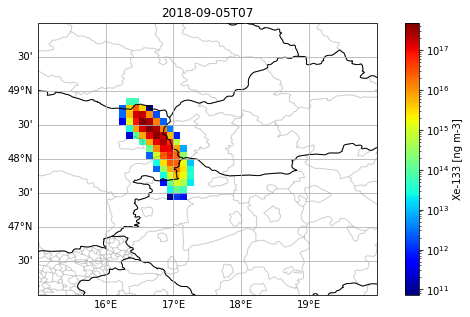

In [8]:
t_ind = 6
h_ind = 0
pointspec = 0
#data selection
mass = data.spec001_mr.isel(time=[t_ind], height=[h_ind], pointspec=[pointspec])
#mass = mass[dict(latitude=slice(30,50), longitude=slice(5,25))]
mass = mass.where(mass!=0)

extent = [15,20,46,50]
norm = colors.LogNorm() 

fig, ax= plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

mass.plot(ax=ax, cmap="jet", norm=norm, transform=ccrs.PlateCarree())

ax.set_title(data.time.values[t_ind].astype('datetime64[h]'))

add_map(ax, extent=extent)

#ax.scatter(16.3738,48.2082,s=200, label="Vienna", color="yellow", edgecolor="black", marker="*")
#ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")

#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/figures/hko_T{t_ind}.png")
plt.show()

# Full footprint

Text(0.5, 1.0, 'Footprint of Darwin station 2012')

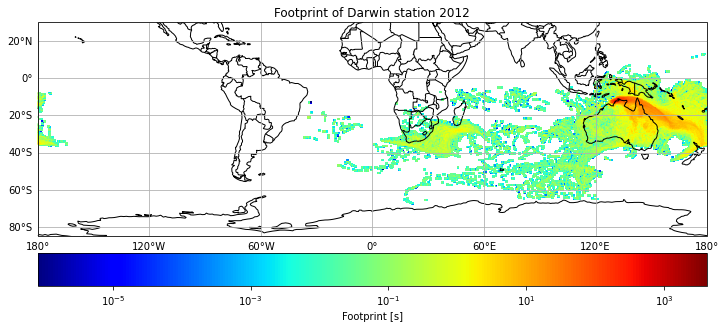

In [29]:
pointspec=[3,4,5]
if type(pointspec) != list:
    sum_dict = dict(dim=["time"])
else:
    sum_dict = dict(dim=["time", "pointspec"])

cmap = "jet"
extent = [-180,180,-85,30]
norm = colors.LogNorm() 

fig, ax = plt.subplots(1, 1, figsize=(12,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
add_map(ax, extent=extent)

mass = data.spec001_mr[dict(pointspec=pointspec)].sum(**sum_dict)
mass = mass.where(mass!=0)
vmin = np.min(mass).values
vmax = np.max(mass).values

mass.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(),
          
         cbar_kwargs=dict(label="Footprint [s]",
                         orientation="horizontal",
                         pad=0.05))
ax.set_title("Footprint of Darwin station 2012")
#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/figures/australia/dar_full_12.png")

# Differences between footprints

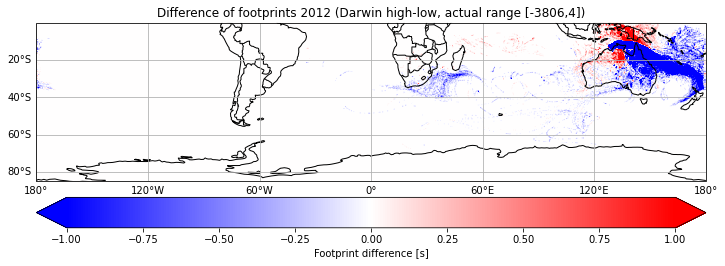

In [30]:
pointspec1 = [3]
pointspec2 = [5]

if type(pointspec1)!=list and type(pointspec2) != list:
    sum_dict = dict(dim=["time"])
else:
    sum_dict = dict(dim=["time", "pointspec"])
mass1 = data.spec001_mr[dict(pointspec=pointspec1)].sum(**sum_dict)
mass2 = data.spec001_mr[dict(pointspec=pointspec2)].sum(**sum_dict)
#diff = data.spec001_mr[dict(pointspec=[pointspec1, pointspec2])].sum(dim="time").diff(dim="pointspec")
#.sum(**sum_dict)
diff = mass2 - mass1

cmap = "bwr"#["jet"]#

extent = [-180,180,-85,0]
vmin = -1
vmax = 1
min_val = np.min(diff.values)
max_val = np.max(diff.values)

fig, ax = plt.subplots(1, 1, figsize=(12,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
add_map(ax, extent=extent)

#mass = data.spec001_mr[dict(pointspec=pointspec)].sum(dim="time")
#mass = mass.where(mass!=0)


diff.plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(),
          vmin=vmin, vmax=vmax,
          cbar_kwargs=dict(label="Footprint difference [s]",
                         orientation="horizontal",
                         pad=0.05))
ax.set_title(f"Difference of footprints 2012 (Darwin high-low, actual range [{min_val:.{0}f},{max_val:.{0}f}])")
#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/figures/australia/dar_high_vs_low_12.png")

# Assign Country to data and choose

In [34]:
#ax.set_title(f"Difference of footprints 2009 (Darwin-Wollongong, actual range [{min_val:.{0}f},{max_val:.{0}f}])")
#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/figures/dar_woll_diff_09")

In [36]:
def xr_to_gdf(xarr, *data_variables, crs="EPSG:4326"):
    df = xarr.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
        df[data_variables[0]], 
        geometry=gpd.points_from_xy(df.longitude, df.latitude), 
        crs=crs
    )
    for i, dv in enumerate(data_variables):
        if i == 0:
            continue
        gdf[dv] = df[dv]
    return gdf
def add_country_names(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = gpd.GeoDataFrame(world[["name"]], geometry=world.geometry)
    gdf = gpd.sjoin(gdf, world, how="left").drop(columns=["index_right"])
    return gdf
    
def country_intersections(gdf, country, crs="EPSG:4326"):    
    assert country in gdf.name.values, f"No country found with name {country} in GeoDataFrame"
    ov_count = gdf[gdf.name == country]
    ov_rest = gdf[gdf.name != country]
    ov_other = gdf[(gdf.name != country) & (gdf.name.notnull())]
    ov_sea = gdf[gdf.name.isnull()]
    ret = dict(
        country = ov_count, 
        rest = ov_rest, 
        other_countries = ov_other, 
        sea = ov_sea)
    return ret

In [34]:
mass = data.spec001_mr[dict(pointspec=[0,1,2])].sum(dim=["time", "pointspec"])[0]
gdf = xr_to_gdf(mass, "spec001_mr")
gdf = add_country_names(gdf)
#gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf.pkl")
ci = country_inersections(gdf, "Australia")
#intersections = country_inersections(mass, "Australia")

In [35]:
gdf.to_pickle("/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/gdf_woll_12.pkl")

In [95]:
columns=["Station","Year","Total [s]", "Australia [%]", "Other countries [%]", "Ocean [%]"]
df = pd.DataFrame(columns=columns)
direc="/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20121123-20121207/"
l = []
for y in ["09", "12"]:
    for stat in ["woll", "dar"]:
    
        l.append("Wollongong" if stat == "woll" else "Darwin")
        l.append("20"+y)
        path = f"gdf_{stat}_{y}.pkl"
        print(path)
        gdf = pd.read_pickle(direc+path)
        ret = country_intersections(gdf, "Australia")
        tot = gdf.spec001_mr.sum()
        l.append(round(tot, 0))
        for key in ret.keys():
            if key == "rest":
                continue
            l.append(round(ret[key].spec001_mr.sum()/tot*100, 2))
        df = df.append(dict(zip(columns,l)), ignore_index=True)
        l = []

gdf_woll_09.pkl
gdf_dar_09.pkl
gdf_woll_12.pkl
gdf_dar_12.pkl


In [96]:
df

,Station,Year,Total [s],Australia [%],Other countries [%],Ocean [%]
0,Wollongong,2009,41876.0,19.52,2.37,78.11
1,Darwin,2009,49550.0,34.31,0.47,65.23
2,Wollongong,2012,50143.0,31.07,0.65,68.28
3,Darwin,2012,41694.0,21.27,0.97,77.76


<AxesSubplot:>

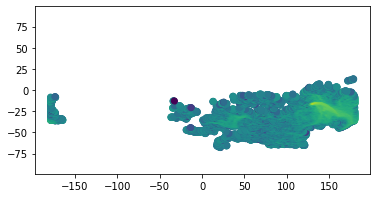

In [81]:
gdf.plot(column="spec001_mr", norm=colors.LogNorm())

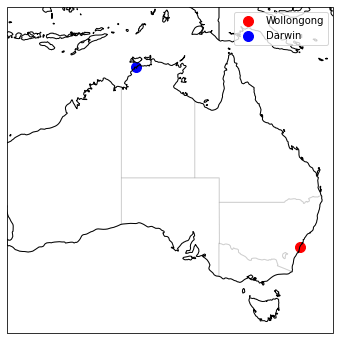

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(12,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
add_map(ax, extent=[115,155,-45,-5], grid=False)
ax.scatter(150.906219, -34.443655, label="Wollongong", color="red", s=100)
ax.scatter(130.841251,-12.396163, label="Darwin", color="blue", s=100)
ax.legend()

# Animation

In [ ]:
#for vmin
mass = data.spec001_mr.where(data.spec001_mr!=0)

#height index, vmin, vmax for cbar
h_ind = 0
vmin = np.min(mass.isel(pointspec=[0])).values
vmax = np.max(mass.isel(pointspec=[0])).values
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[0,180,-85,-0]

cmap = "jet"
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    mass = data.spec001_mr.isel(time=[ind], height=[h_ind], pointspec=[0])
    mass = mass.where(mass!=0)
    if len(fig.axes)==1:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(), 
                  cbar_kwargs=dict(label="Footprint [s]"))
    else:
        mass.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, 
                  norm=norm, 
                  transform=ccrs.PlateCarree(),
                  add_colorbar=False)
    ax.set_title(data.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/animations/tasmania.gif")

# Compare two datasets

In [6]:
def select_extent(xarr, lon1, lon2, lat1, lat2):
    xarr = xarr.where((xarr.longitude >= lon1) & (xarr.longitude <= lon2), drop=True)
    xarr = xarr.where((xarr.latitude >= lat1) & (xarr.latitude <= lat2), drop=True)
    return xarr

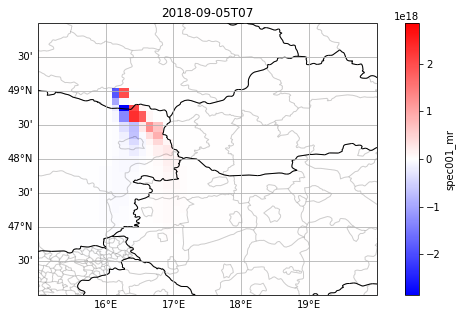

In [35]:
xarr = difference.sum(dim=["height","time"])

t_ind = 6
h_ind = 0
pointspec = 0
#data selection
extent = [16,17,46,50]
norm = None# colors.LogNorm() 

fig, ax= plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

xarr.plot(ax=ax, cmap="bwr", norm=norm, transform=ccrs.PlateCarree())

ax.set_title(data.time.values[t_ind].astype('datetime64[h]'))

add_map(ax, extent=extent)

#ax.scatter(16.3738,48.2082,s=200, label="Vienna", color="yellow", edgecolor="black", marker="*")
#ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")

#fig.savefig(f"/mnt/lustre01/pf/b/b381737/python_scripts/figures/hko_T{t_ind}.png")
plt.show()

1914299000.0
3.5516213e+18


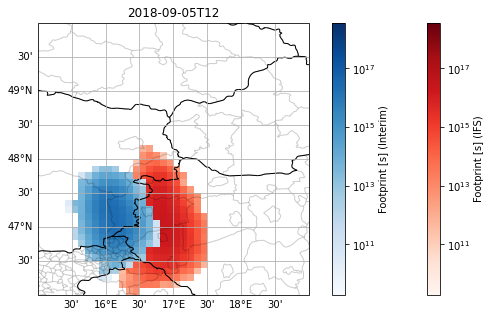

In [10]:
#for vmin
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/OD20180905/grid_conc_20180905000000.nc"
data1 = xr.open_dataset(file_path)
mass1 = data1.spec001_mr
file_path = "/work/bb1170/RUN/b381737/software/flexpart_v10.4_3d7eebf/output/EI20180905/grid_conc_20180905000000.nc"
data2 = xr.open_dataset(file_path)
mass2 = data2.spec001_mr
mass2 = select_extent(mass2, 5, 25, 40, 55)

mass1 = mass1.where(mass1!=0)
mass2 = mass2.where(mass2!=0)



#height index, vmin, vmax for cbar
h_ind = 0
vmin = min([np.min(mass1.isel(pointspec=[0])).values, np.min(mass2.isel(pointspec=[0])).values])
vmax = max([np.max(mass1.isel(pointspec=[0])).values, np.max(mass2.isel(pointspec=[0])).values])
print(vmin)
print(vmax)

#box to be shown TODO: prevent error if not standard projection
extent=[15, 19, 46, 50]

cmaps = ["Reds", "Blues"]
labels = ["Footprint [s] (IFS)", "Footprint [s] (Interim)"]#["Footprint [s] (Interim)", "Footprint [s] (IFS)"]
norm = colors.LogNorm()

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw=dict(projection=ccrs.PlateCarree()))

#total number of frames
frames=len(data1.time.values)
#milliseconds between frames
interval=100

def index_mod(index):
    return index

def add_to_ax(ax):
    #ax.scatter(114.1742, 22.3025,s=200, label="hko", color="yellow", edgecolor="black", marker="*")
    #ax.scatter(16.1469, 49.0845, s=100, label="Power plant", color="red", marker="^")
    return ax

def animate(index):
    ind = index_mod(index)
    ax.clear()
    for i, mass in enumerate([mass1,mass2]):
        mass = mass.isel(dict(time=ind, height=0))
        mass = mass.where(mass!=0)
        if len(fig.axes)==(i+1):
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(), 
                      cbar_kwargs=dict(label=labels[i]))
        else:
            mass.plot(ax=ax, cmap=cmaps[i], vmin=vmin, vmax=vmax, 
                      norm=norm, 
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False)
    ax.set_title(data1.time.values[ind].astype('datetime64[h]'))
    add_map(ax, extent=extent)
    add_to_ax(ax)

ani = animation.FuncAnimation(fig, animate, frames, interval=interval, blit=False)
ani.save("/mnt/lustre01/pf/b/b381737/python_scripts/animations/tutorial/vienna_comparision2.gif")